In [1]:
import glob
import pandas as pd
import pybedtools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pybedtools

In [ ]:
#group_name = 'L23_IT_CTX_Glut'

In [1]:
ct = group_name
res = 25000
ddir = f'/data/female-amb/Diff.Result/CellType.Age.Diff.Domain/{ct}'
_dir = '/home/qzeng_salk_edu/project'
_min = 2e-308

NameError: name 'group_name' is not defined

In [4]:
binall = pd.read_csv(f'{_dir}/binall.csv',  index_col =0)
binall.columns = ['chrom', 'start','end']

In [5]:
all_diff_domain = pd.read_csv('/home/qzeng_salk_edu/project/240424_domain_gene/ALL.Diff.Domain.csv', index_col = 0)
ct_diff_domain = all_diff_domain[all_diff_domain['celltype'] == ct]
ct_diff_domain =  ct_diff_domain[(ct_diff_domain['18mo-8wk'] > 0.05)]
ct_diff_domain = pd.concat([ct_diff_domain, binall], axis = 1).dropna()
ct_diff_domain = ct_diff_domain[[ 'chrom', 'start', 'end','8wk', '9mo', '18mo', '18mo-8wk', 'celltype']]
ct_diff_domain.head()

,chrom,start,end,8wk,9mo,18mo,18mo-8wk,celltype
chr1_657,chr1,16425000,16450000,0.100000,0.066667,0.151111,0.051111,L23_IT_CTX_Glut
chr1_1461,chr1,36525000,36550000,0.124444,0.186667,0.220000,0.095556,L23_IT_CTX_Glut
chr1_2319,chr1,57975000,58000000,0.066667,0.097778,0.142222,0.075556,L23_IT_CTX_Glut
chr1_3498,chr1,87450000,87475000,0.131111,0.137778,0.224444,0.093333,L23_IT_CTX_Glut
chr1_3510,chr1,87750000,87775000,0.302222,0.244444,0.360000,0.057778,L23_IT_CTX_Glut


In [6]:
print(f"{ct_diff_domain.shape[0]} diff domain boundary")

132 diff domain boundary


## get TAD range

In [7]:
leg = [f'{ct}.{age}' for age in ['8wk','9mo','18mo']]
ddir = f'/data/female-amb/Diff.Result/CellType.Age.Diff.Domain/{ct}'

In [8]:
bound_count_ct = pd.read_hdf(f'{ddir}/{ct}_boundcount.hdf', key='data').loc[leg]
cell_count_ct = pd.read_csv(f'{ddir}/{ct}_cellcount.csv.gz', index_col=0, header=0).loc[leg]['count']
bound_prob_ct = bound_count_ct /np.array(cell_count_ct)[:, None]
bound_prob_ct= bound_prob_ct.T
bound_prob_ct.head()

,L23_IT_CTX_Glut.8wk,L23_IT_CTX_Glut.9mo,L23_IT_CTX_Glut.18mo
chr1_0,1.0,1.0,1.0
chr1_1,0.0,0.0,0.0
chr1_2,0.0,0.0,0.0
chr1_3,0.0,0.0,0.0
chr1_4,0.0,0.0,0.0


In [9]:
bd_8wk = bound_prob_ct[f'{ct}.8wk']
def find_nearest_domain(reference_index, bd_8wk):
    cutoff= 0.1

    # Find the position of the reference index
    pos = bd_8wk.index.get_loc(reference_index)
    
    # Split the series into two parts: before and after the reference index
    before = bd_8wk.iloc[:pos][bd_8wk.iloc[:pos] > cutoff]
    after = bd_8wk.iloc[pos + 1:][bd_8wk.iloc[pos + 1:] > cutoff]
    
    # Find the nearest index with value > 0.1 before and after the reference index
    nearest_before = before.index[-1] if not before.empty else None
    nearest_after = after.index[0] if not after.empty else None
    return nearest_before, nearest_after

In [10]:
all_tad_start = []
all_tad_end = []

for diff_domain in ct_diff_domain.index:
    nearest_before, nearest_after = find_nearest_domain(diff_domain, bd_8wk)
    nerest_tad_start = int(nearest_before.split('_')[-1])* res
    nerest_tad_end = int(nearest_after.split('_')[-1])* res + res

    all_tad_start.append(nerest_tad_start)
    all_tad_end.append(nerest_tad_end)

In [11]:
#slop = 500000
ct_diff_domain['tad_start'] = all_tad_start
ct_diff_domain['tad_end'] = all_tad_end

## inersect with gene

In [12]:
ct_diff_domain = ct_diff_domain[['chrom', 'tad_start', 'tad_end', '8wk', '9mo', '18mo', '18mo-8wk', 'celltype', 'start', 'end',]]

In [13]:
genes = pd.read_csv('/home/qzeng_salk_edu/project/240424_domain_gene/mm10.gene.bed', sep = '\t', header = None)
genes.columns = ['gene_chr','gene_start','gene_end','gene_name','strand','gene_type', 'gene_length']
genes.head()

,gene_chr,gene_start,gene_end,gene_name,strand,gene_type,gene_length
0,chr1,3073253,3074322,4933401J01Rik,+,TEC,1069
1,chr1,3102016,3102125,Gm26206,+,snRNA,109
2,chr1,3205901,3671498,Xkr4,-,protein_coding,465597
3,chr1,3252757,3253236,Gm18956,+,processed_pseudogene,479
4,chr1,3365731,3368549,Gm37180,-,TEC,2818


In [14]:
genes_bed = pybedtools.BedTool.from_dataframe(genes)
ct_diff_domain_bed = pybedtools.BedTool.from_dataframe(ct_diff_domain)
# Find overlaps
overlaps = genes_bed.intersect(ct_diff_domain_bed, wa=True, wb=True, f =0.9)
overlaps_df = overlaps.to_dataframe(names = genes.columns.tolist() + ct_diff_domain.columns.tolist())
overlaps_df.head()

,gene_chr,gene_start,gene_end,gene_name,strand,gene_type,gene_length,chrom,tad_start,tad_end,8wk,9mo,18mo,18mo-8wk,celltype,start,end
0,chr1,16208197,16210517,Gm38249,-,TEC,2320,chr1,16125000,16475000,0.100000,0.066667,0.151111,0.051111,L23_IT_CTX_Glut,16425000,16450000
1,chr1,16228506,16244062,Gm28095,+,lncRNA,15556,chr1,16125000,16475000,0.100000,0.066667,0.151111,0.051111,L23_IT_CTX_Glut,16425000,16450000
2,chr1,16253592,16267921,Gm7568,+,lncRNA,14329,chr1,16125000,16475000,0.100000,0.066667,0.151111,0.051111,L23_IT_CTX_Glut,16425000,16450000
3,chr1,36506562,36506702,Gm47280,+,miRNA,140,chr1,36500000,36575000,0.124444,0.186667,0.220000,0.095556,L23_IT_CTX_Glut,36525000,36550000
4,chr1,36511867,36528237,Cnnm3,+,protein_coding,16370,chr1,36500000,36575000,0.124444,0.186667,0.220000,0.095556,L23_IT_CTX_Glut,36525000,36550000


In [15]:
print(f"{overlaps_df.shape[0]} genes overlap with the TAD boundary")

2385 genes overlap with the TAD boundary


In [16]:
overlaps_df.to_csv('All.Overlap.Domain.Genes.csv')

In [17]:
deg_dir = f'/data/female-amb/Diff.Result/DEG.stats/{ct}'
expr = pd.read_hdf(f'{deg_dir}/expr.hdf').T
use_genes = expr[expr.sum(axis = 1) > 0.1].index
stats = np.load(f"{deg_dir}/{ct}.2mo-{ct}.18mo.npz") #fc:(2mo/18mo)

In [18]:
all_gene_result = pd.DataFrame({'fc': (expr[f'{ct}.18mo'] /expr[f'{ct}.2mo']).values,'fdr':stats['fdr']}, index = expr.index).loc[use_genes]
all_gene_result['log2(18mo/2mo)'] = np.log2(all_gene_result['fc']) 
all_gene_result['-log10(padj)'] = -np.log10(all_gene_result['fdr'] + _min)
all_gene_result =all_gene_result[all_gene_result['fdr'] != 1]
all_gene_result = all_gene_result[~all_gene_result.index.str.startswith('Gm')]
deg_result = all_gene_result[(all_gene_result['fdr'] < 0.01) & (abs(all_gene_result['log2(18mo/2mo)']) > 0.2)]

In [19]:
#all_gene_result = all_gene_result.loc[all_gene_result.index.isin(overlaps_df['gene_name'].values)]

In [20]:
overlap_deg_result = deg_result.loc[deg_result.index.isin(overlaps_df['gene_name'].values)]
overlap_deg_result['gene_length'] = overlap_deg_result.index.map(overlaps_df.set_index('gene_name')['gene_length'].to_dict())
overlap_deg_result['abs_log2(18mo/2mo)'] = abs(overlap_deg_result['log2(18mo/2mo)'])
overlap_deg_result.sort_values('fdr').head()

,fc,fdr,log2(18mo/2mo),-log10(padj),gene_length,abs_log2(18mo/2mo)
gene,,,,,,
Usp7,0.558935,6.196643e-48,-0.839249,47.207844,102713,0.839249
B230209E15Rik,1.436485,1.300288e-44,0.522542,43.885960,85456,0.522542
Stx1a,0.465792,4.211526e-43,-1.102242,42.375560,27618,1.102242
Fbxo41,0.510290,2.264741e-36,-0.970611,35.644981,33420,0.970611
Sdk1,0.455411,7.596232e-34,-1.134760,33.119402,974096,1.134760


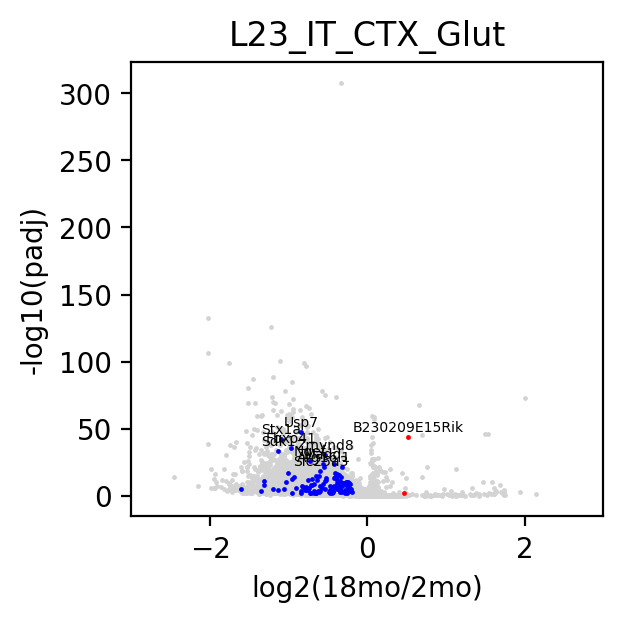

In [21]:
ncols = 1
nrows = 1

fig, ax = plt.subplots(figsize = (ncols*3,nrows*3), 
                         ncols = ncols, nrows = nrows, 
                         dpi = 200, constrained_layout = True)

sns.scatterplot(data = all_gene_result,
                    linewidth = 0,
                    ax = ax,
                    color = 'lightgrey',
                    s = 3,
                    x = 'log2(18mo/2mo)',
                    y = '-log10(padj)')

sns.scatterplot(data = overlap_deg_result[overlap_deg_result['log2(18mo/2mo)'] < 0],
                    linewidth = 0,
                    ax = ax,
                    color = 'blue',
                    s = 3,
                    x = 'log2(18mo/2mo)',
                    y = '-log10(padj)')

sns.scatterplot(data = overlap_deg_result[overlap_deg_result['log2(18mo/2mo)'] > 0],
                    linewidth = 0,
                    ax = ax,
                    color = 'red',
                    s = 3,
                    x = 'log2(18mo/2mo)',
                    y = '-log10(padj)')
ax.set_title(ct)
ax.set(xlim = (-3,3))

top_genes = overlap_deg_result[(overlap_deg_result['abs_log2(18mo/2mo)'] > 0.5)]
top_genes = top_genes.sort_values('fdr').head(10)
for _, row in top_genes.iterrows():
    ax.annotate(row.name, (row['log2(18mo/2mo)'], row['-log10(padj)']), 
                textcoords="offset points", xytext=(0,2), ha='center', fontsize = 5)


In [22]:
overlap_deg_result.to_csv('DiffExpress.DomainGene.csv')